# Data Science Regression Project: Predicting Home Prices in Banglore

When considering purchasing a house, potential home buyers look at factors such as location, property size, proximity to amenities, and price. The impact of demonetization, enforcement of the Real Estate (Regulation and Development) Act (RERA), and mistrust in property developers led to a 7% drop in housing units sold across India in 2017, with Bengaluru property prices falling by nearly 5% in the latter half of the year, according to Knight Frank. For example, the market offers over 9,000 apartment projects in the ₹42-52 lakh range, 7,100 in the ₹52-62 lakh range, and 5,000 in the ₹15-25 lakh range, highlighting the varied budget segments available to potential homeowners. Accurately predicting home prices helps buyers make informed decisions, ensures fair market value, and assists investors in identifying lucrative opportunities.


This data science project series walks through the step-by-step process of how to build a real estate price prediction website. We will first build a model using sklearn and linear regression using the Banglore home prices dataset from kaggle.com. The second step would be to write a Python flask server that uses the saved model to serve HTTP requests. Third component is the website built in HTML, css, and javascript that allows user to enter their home square ft area, bedrooms etc and it will call python flask server to retrieve the predicted price. During model building, we will cover almost all data science concepts such as data load and cleaning, outlier detection and removal, feature engineering, dimensionality reduction, gridsearchcv for hyperparameter tunning, k-fold cross validation, etc.

#### Dataset is downloaded from here: https://www.kaggle.com/amitabhajoy/bengaluru-house-price-data

In [ ]:
import pandas as pd
import numpy as np
import pickle
import json
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, ShuffleSplit, cross_val_score, GridSearchCV
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.tree import DecisionTreeRegressor

In [5]:
df1 = pd.read_csv('Bengaluru_House_Data.csv')
df1.head()

,area_type,availability,location,size,society,total_sqft,bath,balcony,price
0,Super built-up Area,19-Dec,Electronic City Phase II,2 BHK,Coomee,1056,2.0,1.0,39.07
1,Plot Area,Ready To Move,Chikka Tirupathi,4 Bedroom,Theanmp,2600,5.0,3.0,120.00
2,Built-up Area,Ready To Move,Uttarahalli,3 BHK,NaN,1440,2.0,3.0,62.00
3,Super built-up Area,Ready To Move,Lingadheeranahalli,3 BHK,Soiewre,1521,3.0,1.0,95.00
4,Super built-up Area,Ready To Move,Kothanur,2 BHK,NaN,1200,2.0,1.0,51.00


In [8]:
df1.shape

(13320, 9)

In [17]:
df1['area_type'].value_counts()

Super built-up  Area    8790
Built-up  Area          2418
Plot  Area              2025
Carpet  Area              87
Name: area_type, dtype: int64

#### Drop features that are not required to build our model

In [24]:
df2 = df1.drop(['area_type','availability', 'balcony', 'society'], axis = 'columns')
df2.head()

,location,size,total_sqft,bath,price
0,Electronic City Phase II,2 BHK,1056,2.0,39.07
1,Chikka Tirupathi,4 Bedroom,2600,5.0,120.00
2,Uttarahalli,3 BHK,1440,2.0,62.00
3,Lingadheeranahalli,3 BHK,1521,3.0,95.00
4,Kothanur,2 BHK,1200,2.0,51.00


### Data Cleaning: Handle NA values

In [25]:
df2.isnull().sum()

location       1
size          16
total_sqft     0
bath          73
price          0
dtype: int64

In [26]:
df3 = df2.dropna()
df3.isnull().sum()

location      0
size          0
total_sqft    0
bath          0
price         0
dtype: int64

In [27]:
df3.shape

(13246, 5)

### Feature Engineering

#### Add new feature(integer) for bhk (Bedrooms Hall Kitchen)

In [30]:
df3['size'].unique()

array(['2 BHK', '4 Bedroom', '3 BHK', '4 BHK', '6 Bedroom', '3 Bedroom',
       '1 BHK', '1 RK', '1 Bedroom', '8 Bedroom', '2 Bedroom',
       '7 Bedroom', '5 BHK', '7 BHK', '6 BHK', '5 Bedroom', '11 BHK',
       '9 BHK', '9 Bedroom', '27 BHK', '10 Bedroom', '11 Bedroom',
       '10 BHK', '19 BHK', '16 BHK', '43 Bedroom', '14 BHK', '8 BHK',
       '12 Bedroom', '13 BHK', '18 Bedroom'], dtype=object)

In [32]:
df3['bhk'] = df3['size'].apply(lambda x : int(x.split(' ')[0]))

C:\Users\matin\AppData\Local\Temp\ipykernel_14292\3847263516.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df3['bhk'] = df3['size'].apply(lambda x : int(x.split(' ')[0]))


In [33]:
df3.head()

,location,size,total_sqft,bath,price,bhk
0,Electronic City Phase II,2 BHK,1056,2.0,39.07,2
1,Chikka Tirupathi,4 Bedroom,2600,5.0,120.00,4
2,Uttarahalli,3 BHK,1440,2.0,62.00,3
3,Lingadheeranahalli,3 BHK,1521,3.0,95.00,3
4,Kothanur,2 BHK,1200,2.0,51.00,2


In [35]:
df3['bhk'].unique()

array([ 2,  4,  3,  6,  1,  8,  7,  5, 11,  9, 27, 10, 19, 16, 43, 14, 12,
       13, 18], dtype=int64)

In [41]:
df3[df3['bhk']>20]

,location,size,total_sqft,bath,price,bhk
1718,2Electronic City Phase II,27 BHK,8000,27.0,230.0,27
4684,Munnekollal,43 Bedroom,2400,40.0,660.0,43


In [42]:
df3['total_sqft'].unique()

array(['1056', '2600', '1440', ..., '1133 - 1384', '774', '4689'],
      dtype=object)

#### Explore total_sqft feature

In [53]:
def is_float(x):
    try:
        float(x)
    except:
        return False
    return True

In [54]:
df3[~df3['total_sqft'].apply(is_float)].head(10)

,location,size,total_sqft,bath,price,bhk
30,Yelahanka,4 BHK,2100 - 2850,4.0,186.000,4
122,Hebbal,4 BHK,3067 - 8156,4.0,477.000,4
137,8th Phase JP Nagar,2 BHK,1042 - 1105,2.0,54.005,2
165,Sarjapur,2 BHK,1145 - 1340,2.0,43.490,2
188,KR Puram,2 BHK,1015 - 1540,2.0,56.800,2
410,Kengeri,1 BHK,34.46Sq. Meter,1.0,18.500,1
549,Hennur Road,2 BHK,1195 - 1440,2.0,63.770,2
648,Arekere,9 Bedroom,4125Perch,9.0,265.000,9
661,Yelahanka,2 BHK,1120 - 1145,2.0,48.130,2
672,Bettahalsoor,4 Bedroom,3090 - 5002,4.0,445.000,4


##### Above shows that total_sqft can be a range (e.g. 2100-2850). For such case we can just take average of min and max value in the range. There are other cases such as 34.46Sq. Meter which one can convert to square ft using unit conversion. I am going to just drop such corner cases to keep things simple

In [80]:
def convert_sqft_to_num(x):
    x= str(x)
    tokens = x.split('-')
    if len(tokens) == 2:
        return (float(tokens[0])+float(tokens[1]))/2
    try:
        return float(x)
    except:
        return None  

##### It is obvious that for the file below, the function didn't return anything since it is neither split by '-' nor a float. 

In [84]:
convert_sqft_to_num('34.46Sq. Meter	')

In [91]:
df4 = df3.copy()
df4['total_sqft'] = df4['total_sqft'].apply(convert_sqft_to_num)

[df4.iloc[i,2] for i in [30, 122 , 137 , 410]]

[2475.0, 1282.0, 1260.0, 1550.0]

### Feature Engineering

##### Add new feature called price per square feet

In [95]:
df5 = df4.copy()
df5['price_per_sqft'] = df4['price'] * 100000/ df4['total_sqft']
df5.head()

,location,size,total_sqft,bath,price,bhk,price_per_sqft
0,Electronic City Phase II,2 BHK,1056.0,2.0,39.07,2,3699.810606
1,Chikka Tirupathi,4 Bedroom,2600.0,5.0,120.00,4,4615.384615
2,Uttarahalli,3 BHK,1440.0,2.0,62.00,3,4305.555556
3,Lingadheeranahalli,3 BHK,1521.0,3.0,95.00,3,6245.890861
4,Kothanur,2 BHK,1200.0,2.0,51.00,2,4250.000000


In [106]:
len(df5['location'].unique())

1304

##### Examine locations which is a categorical variable. We need to apply dimensionality reduction technique here to reduce number of locations

In [109]:
df5['location'] = df5['location'].apply(lambda x : x.strip())

location_stats = df5.groupby('location')['location'].agg('count').sort_values(ascending = False)
location_stats

location
Whitefield               535
Sarjapur  Road           392
Electronic City          304
Kanakpura Road           266
Thanisandra              236
                        ... 
1 Giri Nagar               1
Kanakapura Road,           1
Kanakapura main  Road      1
Karnataka Shabarimala      1
whitefiled                 1
Name: location, Length: 1293, dtype: int64

In [115]:
len(location_stats[location_stats <= 10])

1052

### Dimensionality Reduction
#### Any location having less than 10 data points should be tagged as "other" location. This way number of categories can be reduced by huge amount. Later on when we do one hot encoding, it will help us with having fewer dummy columns

In [116]:
location_stat_less_than_10 = location_stats[location_stats <=10]
location_stat_less_than_10

location
Basapura                 10
1st Block Koramangala    10
Gunjur Palya             10
Kalkere                  10
Sector 1 HSR Layout      10
                         ..
1 Giri Nagar              1
Kanakapura Road,          1
Kanakapura main  Road     1
Karnataka Shabarimala     1
whitefiled                1
Name: location, Length: 1052, dtype: int64

In [120]:
df5['location'] = df5['location'].apply(lambda x : 'other' if x in location_stat_less_than_10 else x)
len(df5['location'].unique())

242

In [121]:
df5.head()

,location,size,total_sqft,bath,price,bhk,price_per_sqft
0,Electronic City Phase II,2 BHK,1056.0,2.0,39.07,2,3699.810606
1,Chikka Tirupathi,4 Bedroom,2600.0,5.0,120.00,4,4615.384615
2,Uttarahalli,3 BHK,1440.0,2.0,62.00,3,4305.555556
3,Lingadheeranahalli,3 BHK,1521.0,3.0,95.00,3,6245.890861
4,Kothanur,2 BHK,1200.0,2.0,51.00,2,4250.000000


### Outlier Removal Using Business Logic
#### As a data scientist contact the business manager is crucial (who has expertise in real estate), he will confirm that normally square feet per bedroom is 300 (i.e. 2 bhk apartment is a minimum of 600 sqft. For example, a 400 sqft apartment with 2 bhk seems suspicious and can be removed as an outlier. We will remove such outliers by keeping our minimum threshold per bhk to 300 sqft.

In [125]:
df5[df5['total_sqft']/df5['bhk'] < 300].head()

,location,size,total_sqft,bath,price,bhk,price_per_sqft
9,other,6 Bedroom,1020.0,6.0,370.0,6,36274.509804
45,HSR Layout,8 Bedroom,600.0,9.0,200.0,8,33333.333333
58,Murugeshpalya,6 Bedroom,1407.0,4.0,150.0,6,10660.980810
68,Devarachikkanahalli,8 Bedroom,1350.0,7.0,85.0,8,6296.296296
70,other,3 Bedroom,500.0,3.0,100.0,3,20000.000000


#### Check the above data points. There exist 6 bhk apartments with 1020 sqft. Another one is 8 bhk and the total sqft is 600. These are clear data errors that can be removed safely.

In [128]:
df6 = df5[~(df5['total_sqft']/df5['bhk'] < 300)]
df6.shape

(12502, 7)

#### Outlier Removal Using Standard Deviation and Mean

In [130]:
df6['price_per_sqft'].describe()

count     12456.000000
mean       6308.502826
std        4168.127339
min         267.829813
25%        4210.526316
50%        5294.117647
75%        6916.666667
max      176470.588235
Name: price_per_sqft, dtype: float64

#### Here we find that min price per sqft is 267 rs/sqft whereas max is 12000000, this shows a wide variation in property prices. We should remove outliers per location using mean and one standard deviation

In [131]:
def remove_pps_outliers(df):
    df_out = pd.DataFrame()
    for key, subdf in df.groupby('location'):
        m = np.mean(subdf.price_per_sqft)
        st = np.std(subdf.price_per_sqft)
        reduced_df = subdf[(subdf.price_per_sqft>(m-st)) & (subdf.price_per_sqft<=(m+st))]
        df_out = pd.concat([df_out,reduced_df],ignore_index=True)
    return df_out
df7 = remove_pps_outliers(df6)
df7.shape

(10241, 7)

#### Let's check if for a given location how does the 2 BHK and 3 BHK property prices look like

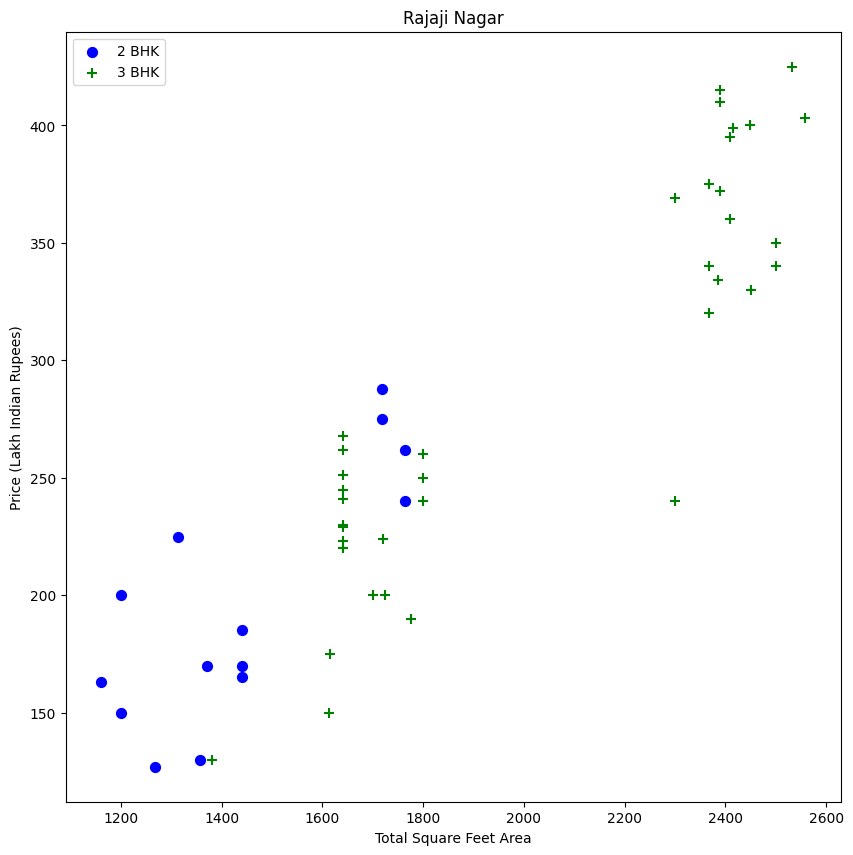

In [141]:
def plot_scatter_chart(df,location):
    bhk2 = df[(df.location==location) & (df.bhk==2)]
    bhk3 = df[(df.location==location) & (df.bhk==3)]
    plt.figure(figsize = (10 , 10))
    plt.scatter(bhk2.total_sqft,bhk2.price,color='blue',label='2 BHK', s=50)
    plt.scatter(bhk3.total_sqft,bhk3.price,marker='+', color='green',label='3 BHK', s=50)
    plt.xlabel("Total Square Feet Area")
    plt.ylabel("Price (Lakh Indian Rupees)")
    plt.title(location)
    plt.legend()
    
plot_scatter_chart(df7,"Rajaji Nagar")

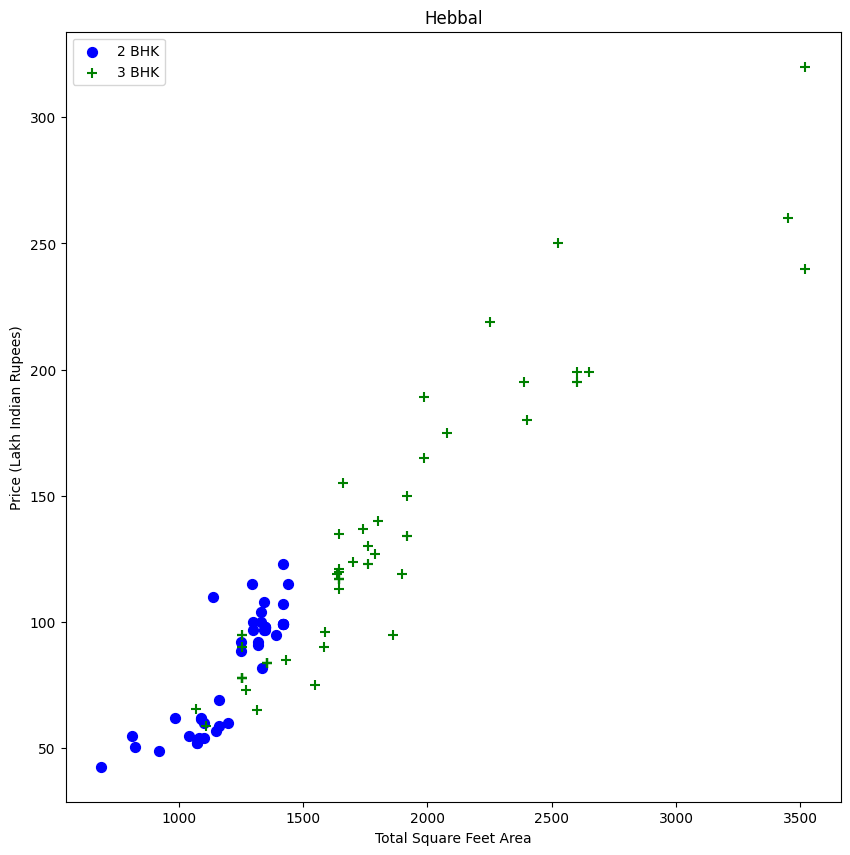

In [136]:
plot_scatter_chart(df7,"Hebbal")

#### We should also remove properties where for the same location, the price of (for example) 3-bedroom apartments is less than 2-bedroom apartments (with the same square feet). What we will do for a given location is build a dictionary of stats per BHK, i.e.

```json
{
    "1": {
        "mean": 4000,
        "std": 2000,
        "count": 34
    },
    "2": {
        "mean": 4300,
        "std": 2300,
        "count": 22
    }
}

    },    
}
Now we can remove those 2 BHK apartments whose price_per_sqft is less than mean price_per_sqft of 1 BHK apartment

In [137]:
def remove_bhk_outliers(df):
    exclude_indices = np.array([])
    for location, location_df in df.groupby('location'):
        bhk_stats = {}
        for bhk, bhk_df in location_df.groupby('bhk'):
            bhk_stats[bhk] = {
                'mean': np.mean(bhk_df.price_per_sqft),
                'std': np.std(bhk_df.price_per_sqft),
                'count': bhk_df.shape[0]
            }
        for bhk, bhk_df in location_df.groupby('bhk'):
            stats = bhk_stats.get(bhk-1)
            if stats and stats['count']>5:
                exclude_indices = np.append(exclude_indices, bhk_df[bhk_df.price_per_sqft<(stats['mean'])].index.values)
    return df.drop(exclude_indices,axis='index')
df8 = remove_bhk_outliers(df7)
df8.shape

(7329, 7)

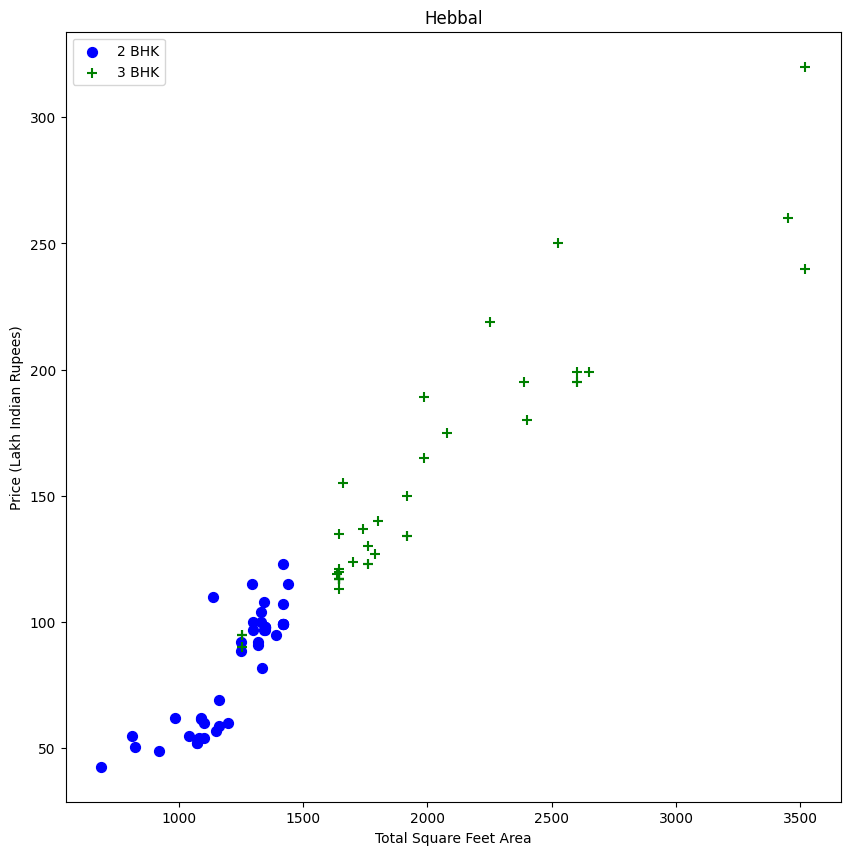

In [138]:
plot_scatter_chart(df8,"Hebbal")

#### Based on the above chart we can see that the data points highlighted in red below are outliers and are being removed due to the remove_bhk_outliers function.

<h3 style="color:green;">Before and after outlier removal</h3>

![Before and after outlier removalhebbalar](hebbal_outliers.png)



Text(0, 0.5, 'Frequency')

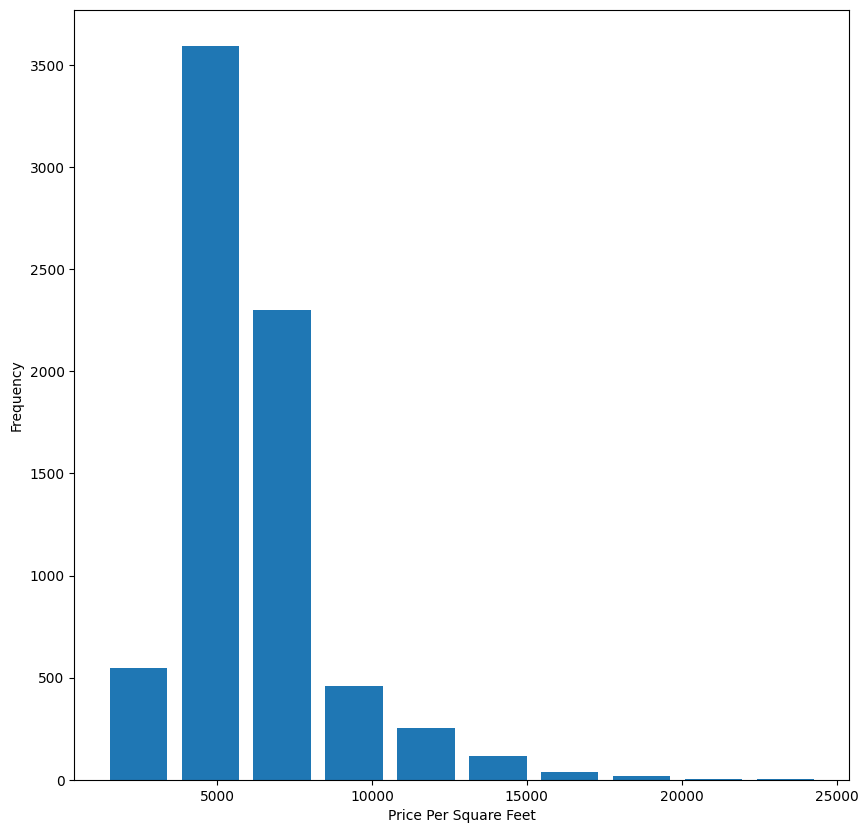

In [146]:
plt.figure(figsize = (10 , 10))
plt.hist(df8['price_per_sqft'], rwidth=0.8)
plt.xlabel('Price Per Square Feet')
plt.ylabel('Frequency')

#### Outlier Removal Using Bathrooms Feature

In [147]:
df8['bath'].unique()

array([ 4.,  3.,  2.,  5.,  8.,  1.,  6.,  7.,  9., 12., 16., 13.])

In [148]:
df8[df8['bath'] > 8]

,location,size,total_sqft,bath,price,bhk,price_per_sqft
3775,KR Puram,9 BHK,4600.0,9.0,200.0,9,4347.826087
5113,Mico Layout,9 BHK,5000.0,9.0,210.0,9,4200.000000
5277,Neeladri Nagar,10 BHK,4000.0,12.0,160.0,10,4000.000000
5660,Raja Rajeshwari Nagar,9 Bedroom,3600.0,9.0,240.0,9,6666.666667
8026,other,11 BHK,5000.0,9.0,360.0,11,7200.000000
8411,other,6 BHK,11338.0,9.0,1000.0,6,8819.897689
8486,other,10 BHK,12000.0,12.0,525.0,10,4375.000000
8575,other,16 BHK,10000.0,16.0,550.0,16,5500.000000
8761,other,9 BHK,4500.0,9.0,500.0,9,11111.111111
9308,other,11 BHK,6000.0,12.0,150.0,11,2500.000000


Text(0, 0.5, 'Frequency')

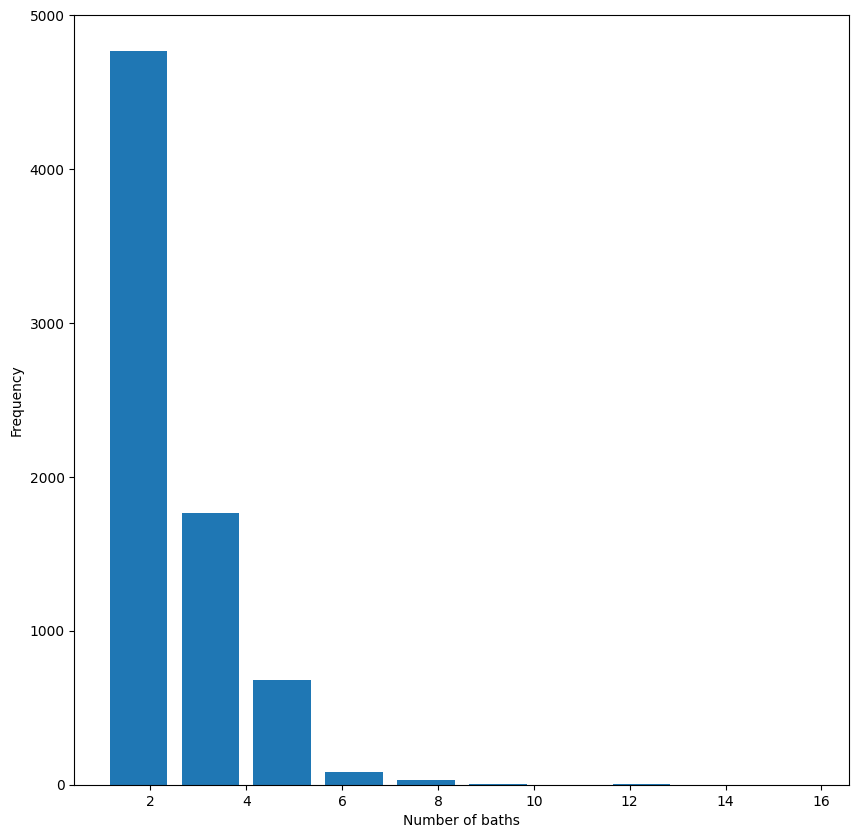

In [149]:
plt.figure(figsize = (10 , 10))
plt.hist(df8['bath'], rwidth=0.8)
plt.xlabel('Number of baths')
plt.ylabel('Frequency')

#### It is unusual to have 2 more bathrooms than number of bedrooms in a home

In [154]:
df9 = df8[df8['bath'] < df8['bhk'] + 2]
df9.shape

(7251, 7)

In [158]:
df10 = df9.drop(['price_per_sqft','size'], axis = 'columns')
df10.head()

,location,total_sqft,bath,price,bhk
0,1st Block Jayanagar,2850.0,4.0,428.0,4
1,1st Block Jayanagar,1630.0,3.0,194.0,3
2,1st Block Jayanagar,1875.0,2.0,235.0,3
3,1st Block Jayanagar,1200.0,2.0,130.0,3
4,1st Block Jayanagar,1235.0,2.0,148.0,2


### Use One Hot Encoding For Location

In [162]:
dummies = pd.get_dummies(df10['location'])
dummies.head(3)

,1st Block Jayanagar,1st Phase JP Nagar,2nd Phase Judicial Layout,2nd Stage Nagarbhavi,5th Block Hbr Layout,5th Phase JP Nagar,6th Phase JP Nagar,7th Phase JP Nagar,8th Phase JP Nagar,9th Phase JP Nagar,...,Vishveshwarya Layout,Vishwapriya Layout,Vittasandra,Whitefield,Yelachenahalli,Yelahanka,Yelahanka New Town,Yelenahalli,Yeshwanthpur,other
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [168]:
df11 = pd.concat([df10 , dummies.drop('other',  axis = 'columns')], axis = 'columns')
df11.head()

,location,total_sqft,bath,price,bhk,1st Block Jayanagar,1st Phase JP Nagar,2nd Phase Judicial Layout,2nd Stage Nagarbhavi,5th Block Hbr Layout,...,Vijayanagar,Vishveshwarya Layout,Vishwapriya Layout,Vittasandra,Whitefield,Yelachenahalli,Yelahanka,Yelahanka New Town,Yelenahalli,Yeshwanthpur
0,1st Block Jayanagar,2850.0,4.0,428.0,4,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1st Block Jayanagar,1630.0,3.0,194.0,3,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1st Block Jayanagar,1875.0,2.0,235.0,3,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1st Block Jayanagar,1200.0,2.0,130.0,3,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1st Block Jayanagar,1235.0,2.0,148.0,2,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [171]:
df12 = df11.drop('location', axis = 'columns')
df12.head(2)

,total_sqft,bath,price,bhk,1st Block Jayanagar,1st Phase JP Nagar,2nd Phase Judicial Layout,2nd Stage Nagarbhavi,5th Block Hbr Layout,5th Phase JP Nagar,...,Vijayanagar,Vishveshwarya Layout,Vishwapriya Layout,Vittasandra,Whitefield,Yelachenahalli,Yelahanka,Yelahanka New Town,Yelenahalli,Yeshwanthpur
0,2850.0,4.0,428.0,4,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1630.0,3.0,194.0,3,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### Build a Model Now...

In [172]:
X = df12.drop('price' , axis = 'columns')
X.head(3)

,total_sqft,bath,bhk,1st Block Jayanagar,1st Phase JP Nagar,2nd Phase Judicial Layout,2nd Stage Nagarbhavi,5th Block Hbr Layout,5th Phase JP Nagar,6th Phase JP Nagar,...,Vijayanagar,Vishveshwarya Layout,Vishwapriya Layout,Vittasandra,Whitefield,Yelachenahalli,Yelahanka,Yelahanka New Town,Yelenahalli,Yeshwanthpur
0,2850.0,4.0,4,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1630.0,3.0,3,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1875.0,2.0,3,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [174]:
y = df12['price']
y.head(3)

0    428.0
1    194.0
2    235.0
Name: price, dtype: float64

In [177]:
X_train , X_test , y_train, y_test = train_test_split(X, y , test_size =0.2 ,random_state=10)
X_train.shape

(5800, 244)

In [179]:
lr_clf = LinearRegression()
lr_clf.fit(X_train, y_train)
lr_clf.score(X_test, y_test)

0.8452277697874362

### Use K Fold cross-validation to measure accuracy of our linear regression model

In [182]:
cv = ShuffleSplit(n_splits = 5 , test_size = 0.2, random_state = 0)
cross_val_score(LinearRegression(), X , y, cv=cv)

array([0.82430186, 0.77166234, 0.85089567, 0.80837764, 0.83653286])

#### We can see that in 5 iterations we get a score above 80% almost every time. This is pretty good but we want to test few other algorithms for regression to see if we can get even better score. We will use GridSearchCV for this purpose.

### Find best model using GridSearchCV

In [188]:
def find_best_model_using_gridsearchcv(X,y):
    algos = {
        'linear_regression' : {
            'model': LinearRegression(),
            'params': {
                'fit_intercept': [True, False], 
                'positive': [True, False]
            }
        },
        'lasso': {
            'model': Lasso(),
            'params': {
                'alpha': [1,2],
                'selection': ['random', 'cyclic']
            }
        },
        'decision_tree': {
            'model': DecisionTreeRegressor(),
            'params': {
                'criterion' : ['squared_error', 'friedman_mse'],
                'splitter': ['best','random']
            }
        }
    }
    scores = []
    cv = ShuffleSplit(n_splits=5, test_size=0.2, random_state=0)
    for algo_name, config in algos.items():
        gs =  GridSearchCV(config['model'], config['params'], cv=cv, return_train_score=False)
        gs.fit(X,y)
        scores.append({
            'model': algo_name,
            'best_score': gs.best_score_,
            'best_params': gs.best_params_
        })

    return pd.DataFrame(scores,columns=['model','best_score','best_params'])

find_best_model_using_gridsearchcv(X,y)

,model,best_score,best_params
0,linear_regression,0.819001,"{'fit_intercept': False, 'positive': False}"
1,lasso,0.687457,"{'alpha': 1, 'selection': 'random'}"
2,decision_tree,0.713844,"{'criterion': 'squared_error', 'splitter': 'be..."


#### Based on above results we can say that LinearRegression gives the best score. Hence we will use that.

### Test the model for few properties

In [198]:
def predict_price(location,sqft,bath,bhk):    
    x = pd.DataFrame(columns=X.columns)
    
    x.loc[0] = np.zeros(len(X.columns))
    
    x.loc[0, 'total_sqft'] = sqft
    x.loc[0, 'bath'] = bath
    x.loc[0, 'bhk'] = bhk
    if location in X.columns:
        x.loc[0, location] = 1
    
    return lr_clf.predict(x)[0]

In [218]:
predict_price('6th Phase JP Nagar',1000, 2, 2)

81.88929546001067

In [243]:
X_test[X_test['6th Phase JP Nagar'] == 1]

,total_sqft,bath,bhk,1st Block Jayanagar,1st Phase JP Nagar,2nd Phase Judicial Layout,2nd Stage Nagarbhavi,5th Block Hbr Layout,5th Phase JP Nagar,6th Phase JP Nagar,...,Vijayanagar,Vishveshwarya Layout,Vishwapriya Layout,Vittasandra,Whitefield,Yelachenahalli,Yelahanka,Yelahanka New Town,Yelenahalli,Yeshwanthpur
77,1180.0,2.0,2,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
85,2003.0,3.0,3,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0


In [245]:
y_test[77]

80.0

This is obvious that the predicted value of the price for **6th Phase JP Nagar** with 1000 square foot area with 2 baths and bedrooms is very close to a real available file with the same features. 

### Export the tested model to a pickle file

In [247]:
with open('banglore_home_prices_model.pickle','wb') as f:
    pickle.dump(lr_clf,f)

### Export location and column information to a file that will be useful later on in our prediction application

In [249]:
columns = {
    'data_columns' : [col.lower() for col in X.columns]
}
with open("columns.json","w") as f:
    f.write(json.dumps(columns))